# IoT over Geostationary Satellite transponder

This notebook is to do a rough computation of the radio budget link from an IoT-like device
received via a geostationary satellite like QO-100

So let's start by importing all of the library:

In [57]:
from rfbudget import *

First lets define few variables that clearly define the capability of the communication, especially the frequency, the bandwidth, and the initial transmitter power.

In [58]:
up_freq = GHz(2.4)
down_freq = GHz(10.486)
transmit_power_dbm = watt_to_dBm(1)
signal_bandwidth = kHz(2.5)
sat_transmit_power_dbm = watt_to_dBm(50)

Lets say that the antenna supported by the IoT-like device (eg buoy or sailor skipper) is a patch antenna so slightly directive because it is directed to the sky and provide limited gain:

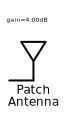

In [59]:
tx_antenna = Antenna(
    name='Patch\nAntenna',
    gain=dB(4),
)
d = into_schemdraw([tx_antenna], {'with_gain': True})

Because the satellite is geostationary, it is at 36500km from the ground. Yet, we need to take into account the elevation of the satellite. Let's say it is at 29° of elevation.

In [60]:
slant = distance_max(degree(29), EARTH_RADIUS + km(35_700))
print("Actual distance to the satellite: {0:.2f}km".format(slant/km(1)))

Actual distance to the satellite: 38614.55km


 So we need to compute the actual free space loss thanks to the Friis formula.

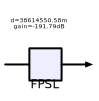

In [61]:

freespace_up = FreeSpacePathLossFriis(
    distance = slant,
    freq = up_freq,
)
d = into_schemdraw([freespace_up], {'with_gain': True})

But we also need to take into account the atmospheric loss. Let's say 1dB.

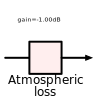

In [62]:
atmo_loss = PathLoss(name="Atmospheric\nloss", loss=dB(1))
d = into_schemdraw([atmo_loss], {'with_gain': True})

The receiving antenna of the satellite is semi-directional so let's assume it has no gain.

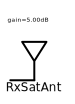

In [63]:
rx_sat_antenna = Antenna(
    name='RxSatAnt',
    gain=dB(5),
    nf=2.5,
)
d = into_schemdraw([rx_sat_antenna], {'with_gain': True})

The uplink budget is thus:

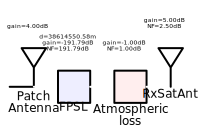

In [64]:
up_budget = budget(
    elements=[tx_antenna, freespace_up, atmo_loss, rx_sat_antenna],
    input_freq=up_freq,
    available_input_power=transmit_power_dbm,
    signal_bandwidth=signal_bandwidth,
    without_oip=True,
    T_receiver=kelvin(580)
)
opt = {'with_gain': True, 'with_nf': True, 'simplified': True}
d = up_budget.schemdraw(opt)
up_budget.display(with_icons=True, options=opt)

Note that in future version, atmospheric, rain attenuation, and polarization loss will be computed.

What about the downlink budget?

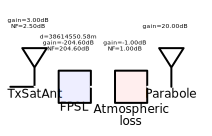

In [65]:
tx_sat_antenna = Antenna(
    name='TxSatAnt',
    gain=dB(3),
    nf=2.5,
)
freespace_down = FreeSpacePathLossFriis(
    distance = slant,
    freq = down_freq,
)
rx_antenna = Antenna(
    name='Parabole',
    gain=dB(20),
)
down_budget = budget(
    elements=[tx_sat_antenna, freespace_down, atmo_loss, rx_antenna],
    input_freq=down_freq,
    available_input_power=sat_transmit_power_dbm,
    signal_bandwidth=signal_bandwidth,
    without_oip=True
)
d = down_budget.schemdraw(opt)
down_budget.display(with_icons=True, options=opt)